# Forecast a multivariate time series

with TensorFlow 2.0

dataset: Brugge field .mat

## What to implement

각 well마다 104개의 모델이 있다. 이 중에서 80개는 training set으로 나머지는 validation set으로 사용한다.

LSTM은 Input sequence 5개 `(t-5)~(t-1)`, Output sequence 1개`t`로 되어있다. Layer 구성은 2개의 LSTM layer, 2개의 dropout layer, 1개의 Dense layer로 한다. 

Inference시에 
- 먼저 day 1004까지(index 앞의 150개)는 그대로 넣어 predict한다.
- 그 다음부터는 이전 5개의 값으로 t에서의 value를 예측한다.
- 가장 과거의 값(t-5)은 잊어버리고 예측한 값을 window에 넣어준다.
- window 안에 있는 새로운 5개 timestep의 value들의 mean을 구한다.
- 구한 mean과 일정한 std 값으로 Gaussian noise가 들어간 값으로 predict 한 값을 replace한다.
- 즉 window의 가장 최근 값은, predict한 값이 아니라, predict_val + gaussian_noise(window_mean, std)가 들어가게 된다.
- 이 window를 가지고 다음 t에서의 value를 예측한다.

## Setup

In [1]:
import random
import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras 
from datetime import datetime
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from os.path import dirname, join as pjoin
random.seed(2)

# tf.debugging.set_log_device_placement(True)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
# Declare constants
DATA_PATH = '../data'
DATA_FILE_NAME = 'Brugge_en_d.mat'
# RESULT_FILE_NAME = 'rmse.csv'
RESULT_FILE_NAME = 'mape.csv'

# TRAIN_SPLIT = 150
BUFFER_SIZE = 1000
BATCH_SIZE = 32
EVALUATION_INTERVAL = 10
EPOCHS = 5

WELL_TO_LEARN = 9

NUM_MODEL = 104
TRUE_MODEL = 88
OBSERVATION_DAY = 150

LSTM_UNITS = 128
DROPOUT_RATE = 0.25
TRAIN_SPLIT = 80
NUM_FEATURES = 4
NUM_FEATURES_USED = 1
INPUT_SEQUENCE = 5
FUTURE_TARGET = 0
STEP = 1

In [3]:
data_dir = pjoin(DATA_PATH, DATA_FILE_NAME)
mat_contents = sio.loadmat(data_dir)

data = mat_contents['en_d'][0, 0]

## Data Preparation

In [4]:
well_dic = {}

for well_index in range(20): # well, Producer P1-P20
    # 'model_num' => dataframe
    model_dic = {}
    well_key = 'P' + str(well_index+1)
    for model_index in range(104): # model, model 1-104
        well_data = np.array([
            data['WOPR'][0,0][well_key][:,model_index],
            data['WBHP'][0,0][well_key][:,model_index],
            data['WWCT'][0,0][well_key][:,model_index],
            data['WWPR'][0,0][well_key][:,model_index]
          ])
        # col1: WOPR, col2: WBHP, col3: WWCT, col4: WWPR
        # row1: day1, ... row 498: day3648
        well_data = well_data.T
        df = pd.DataFrame(
            data=well_data,
            columns=['WOPR', 'WBHP', 'WWCT', 'WWPR']
        )
        model_dic[str(model_index+1)] = df
        
    well_dic[str(well_index+1)] = model_dic

In [5]:
def plot_single_well(well_dic, well_num):
    ax = plt.gca()
    for i in range(104):
        df = well_dic[str(well_num)][str(i+1)]
        if i == TRUE_MODEL-1:
            df.plot(y='WOPR', ax=ax, color='red', linewidth = 5, legend=False)
        else:
            df.plot(y='WOPR', ax=ax, color='gray', legend=False)
            
    plt.show()

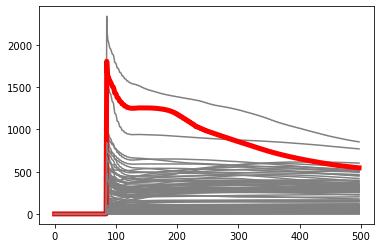

In [6]:
plot_single_well(well_dic, WELL_TO_LEARN)

# Data Preprocessing

In [7]:
well_to_predict = well_dic[str(WELL_TO_LEARN)]

In [9]:
# delte rows where WOPR is zero
def remove_zero_wopr(well):
    for model_index in well:
        df = well_to_predict[model_index]
        well_to_predict[model_index] = df[df.WOPR != 0]

In [10]:
remove_zero_wopr(well_to_predict)

In [11]:
test_model_unprocessed = well_to_predict[str(TRUE_MODEL)]

In [12]:
def serialize_well_dataframe(well):
    serialized_well = np.empty((0, 4))
    end_indice = {}
    start = 0
    
    for model in well:         
#       skip true model
        if model == str(TRUE_MODEL):
            continue
        dataset = well[str(model)].values
        serialized_well = np.concatenate((serialized_well, dataset))
        num_timesteps = dataset.shape[0]
        end_indice[str(model)] = [start, start+num_timesteps]
        start += num_timesteps
    return serialized_well, end_indice

In [13]:
serialized_dataset, end_indice = serialize_well_dataframe(well_to_predict)

In [14]:
def scale_model_together(serialized_dataset):
    scaler = MinMaxScaler()
    scaler.fit(serialized_dataset)
    transformed = scaler.transform(serialized_dataset)
    
    return transformed, scaler

In [15]:
scaled_together_dataset, scaler = scale_model_together(serialized_dataset)

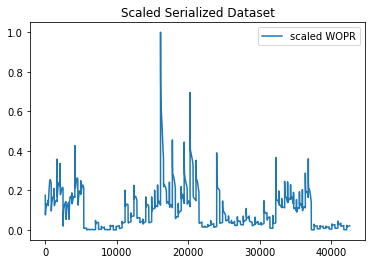

In [16]:
plt.plot(scaled_together_dataset[:,0], label='scaled WOPR')
plt.title('Scaled Serialized Dataset')
plt.legend(loc='best')
plt.show()

In [17]:
# Todo
# Make multivariate dataset
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [18]:
def split_train(test_model):
    model_list = list(range(1, NUM_MODEL + 1))
    train = []
    test = [test_model]
    model_list.remove(test_model)
    for i in range(TRAIN_SPLIT):
        chosen = random.choice(model_list)
        train.append(chosen)
        model_list.remove(chosen)

    val = model_list
    return train, val, test

In [19]:
train_model_list, val_model_list, test_model_list = split_train(test_model=TRUE_MODEL)

In [20]:
print(TRUE_MODEL in train_model_list)
print(TRUE_MODEL in val_model_list)
print(TRUE_MODEL in test_model_list)

False
False
True


In [21]:
def get_dataset(serialized_well, model_list, end_indice):
    dataset_x = np.empty((0, INPUT_SEQUENCE, NUM_FEATURES_USED))
    dataset_y = np.empty((0))

    for model in model_list:
        start_index = end_indice[str(model)][0]
        end_index = end_indice[str(model)][1]
    
        range_multi_x, range_multi_y = multivariate_data(
            serialized_well[start_index:end_index][:, :NUM_FEATURES_USED],
            serialized_well[start_index:end_index][:, 0],
            start_index = 0,
            end_index = end_index - start_index,
            history_size = INPUT_SEQUENCE,
            target_size = FUTURE_TARGET,
            step = STEP,
            single_step = True
        )
        
        dataset_x = np.concatenate((dataset_x, range_multi_x))
        dataset_y = np.concatenate((dataset_y, range_multi_y))

    return dataset_x, dataset_y

In [22]:
new_train_x, new_train_y = get_dataset(scaled_together_dataset, train_model_list, end_indice)
new_val_x, new_val_y = get_dataset(scaled_together_dataset, val_model_list, end_indice)
print(new_train_x.shape, new_train_y.shape)
print(new_val_x.shape, new_val_y.shape)

(32640, 5, 1) (32640,)
(9384, 5, 1) (9384,)


In [23]:
train_data = tf.data.Dataset.from_tensor_slices((new_train_x, new_train_y))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_data = train_data.prefetch(1)
val_data = tf.data.Dataset.from_tensor_slices((new_val_x, new_val_y))
val_data = val_data.batch(BATCH_SIZE).repeat()

# Define model and Train

In [24]:
single_step_model = tf.keras.models.Sequential()

single_step_model.add(tf.keras.layers.LSTM(LSTM_UNITS, batch_input_shape=(BATCH_SIZE, INPUT_SEQUENCE, STEP), activation='relu', stateful=True))
single_step_model.add(tf.keras.layers.Dropout(DROPOUT_RATE))


single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer='adam', loss='mean_squared_error',metrics=['mean_squared_error'])

In [25]:
single_step_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (32, 128)                 66560     
_________________________________________________________________
dropout (Dropout)            (32, 128)                 0         
_________________________________________________________________
dense (Dense)                (32, 1)                   129       
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [26]:
for x, y in val_data.take(1):
  print(single_step_model.predict(x).shape)

(32, 1)


In [27]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=50, verbose=1)

timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = pjoin('..\\logs', 'fit', timestamp)
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir, histogram_freq=1)

# checkpoint_path = pjoin('..\\logs', f"well_{WELL_TO_LEARN}", "model.ckpt-{epoch:04d}")
# checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)


class LossHistory(keras.callbacks.Callback):
    def init(self):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

history = LossHistory()
history.init()

In [28]:
for epoch_idx in range(EPOCHS):
    print ('epochs : ' + str(epoch_idx))
    single_step_model.fit(
        train_data,
        epochs=1,
        steps_per_epoch=new_train_x.shape[0]/BATCH_SIZE,
        verbose=2,
        validation_data=val_data,
        validation_steps=100,
        use_multiprocessing=True,
        callbacks=[history]
#         callbacks=[history, es_callback, tensorboard_callback]
    )
    single_step_model.reset_states()

epochs : 0
Train for 1020.0 steps, validate for 100 steps
1020/1020 - 12s - loss: 7.4308e-04 - mean_squared_error: 7.4308e-04 - val_loss: 2.2429e-05 - val_mean_squared_error: 2.2429e-05
epochs : 1
Train for 1020.0 steps, validate for 100 steps
1020/1020 - 9s - loss: 1.2768e-04 - mean_squared_error: 1.2768e-04 - val_loss: 2.5074e-05 - val_mean_squared_error: 2.5074e-05
epochs : 2
Train for 1020.0 steps, validate for 100 steps
1020/1020 - 9s - loss: 1.1412e-04 - mean_squared_error: 1.1412e-04 - val_loss: 1.0503e-05 - val_mean_squared_error: 1.0503e-05
epochs : 3
Train for 1020.0 steps, validate for 100 steps
1020/1020 - 9s - loss: 1.1277e-04 - mean_squared_error: 1.1277e-04 - val_loss: 1.6864e-05 - val_mean_squared_error: 1.6864e-05
epochs : 4
Train for 1020.0 steps, validate for 100 steps
1020/1020 - 9s - loss: 9.7701e-05 - mean_squared_error: 9.7701e-05 - val_loss: 1.6204e-05 - val_mean_squared_error: 1.6204e-05


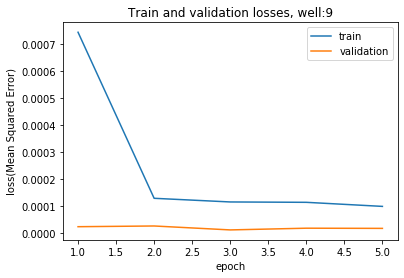

In [29]:
fig = plt.figure()

plt.plot(range(1, EPOCHS+1), history.losses, label='train')
plt.plot(range(1, EPOCHS+1), history.val_losses, label='validation')

plt.ylabel('loss(Mean Squared Error)')
plt.xlabel('epoch')
plt.title(f"Train and validation losses, well:{WELL_TO_LEARN}")
plt.legend(loc='best')

fig_extension = 'png'
img_dir = pjoin('../img', f"well{WELL_TO_LEARN}_losses.{fig_extension}")
plt.show()
fig.savefig(img_dir, format=fig_extension, dpi=300)
fig.clf()

In [ ]:
# scores=single_step_model.evaluate(train_x, train_y, batch_size=BATCH_SIZE)

# Inference

test set Normalize 어떻게 할 것인가?

- 나머지 model들의 scaler_min, scaler_scale의 대표값을 쓴다
- 어떤 대표값을 쓸까? 평균, 중간값, 최대, 최소 등

In [30]:
test_unprocessed_data = scaler.transform(test_model_unprocessed.values)

new_test_x, new_test_y = multivariate_data(
    test_unprocessed_data[:, :NUM_FEATURES_USED],
    test_unprocessed_data[:, 0],
    start_index = 0,
    end_index = test_unprocessed_data.shape[0],
    history_size=INPUT_SEQUENCE,
    target_size=FUTURE_TARGET,
    step=STEP,
    single_step=True
)

print(new_test_x.shape, new_test_y.shape)

(408, 5, 1) (408,)


In [33]:
seq_in = new_test_x[OBSERVATION_DAY-BATCH_SIZE:OBSERVATION_DAY,:,:]
seq_out = new_test_x[:INPUT_SEQUENCE,:1,:].flatten().tolist() + new_test_y[:OBSERVATION_DAY+1].tolist()

In [34]:
pred_count = new_test_x.shape[0] - OBSERVATION_DAY

for i in range(1, pred_count):
    sample_in = seq_in
    pred_out = single_step_model.predict(sample_in)
    seq_out.append(pred_out[-1,:].item())
    seq_in = new_test_x[OBSERVATION_DAY-BATCH_SIZE+i:OBSERVATION_DAY+i,:,:]    

single_step_model.reset_states()

# Evaluate the model

In [ ]:
seq_out_array = np.asarray(seq_out)
prediction_val = (seq_out_array - scaler.min_[0])/ scaler.scale_[0]


true_val = well_to_predict[str(TRUE_MODEL)]
true_val = true_val['WOPR'].to_numpy()
x_axis = range(test_unprocessed_data.shape[0])

fig = plt.figure()
plt.plot(x_axis, true_val, label='ground truth')
plt.plot(x_axis, prediction_val, label='prediction')

plt.ylabel('WOPR')
plt.xlabel('time')
plt.title(f"WOPR forecasting, well: {WELL_TO_LEARN}  true model: {TRUE_MODEL}")
plt.legend(loc='best')

fig_extension = 'png'
img_dir = pjoin('../img', f"well{WELL_TO_LEARN}_prediction.{fig_extension}")
plt.show()
fig.savefig(img_dir, format=fig_extension, dpi=300)
fig.clf()

In [ ]:
# print(prediction_val)
# print(true_val)
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))[0] * 100

mape = mean_absolute_percentage_error(true_val, prediction_val)
print(f"MAPE: {mape}")

In [ ]:
result_dir = pjoin('../result', RESULT_FILE_NAME)

with open(result_dir, "a") as f:
    f.write(f"{WELL_TO_LEARN},{TRUE_MODEL},{mape}\n")
    f.close()

In [ ]:
# After scaling up
# rmse = sqrt(mean_squared_error(prediction_val, true_val))
# print(f"Test RMSE: {rmse}")

In [ ]:
# result_dir = pjoin('../result', RESULT_FILE_NAME)

# with open(result_dir, "a") as f:
#     f.write(f"{WELL_TO_LEARN},{TRUE_MODEL},{rmse}\n")
#     f.close()

In [36]:
tf.keras.backend.clear_session()